## Testing of field curvature
### Imaging setup:
- Objective: Olympus MV PLAPO 1x on MVX10 zoom body (room H45 setup).
- Tube lens standard (Olympus SWTLU-C)
- Camera: **Hamamatsuc Orca Flash 4**
- Test target: Ronchi grating 40 lpp, imaged at different z-positions (stack).
- Medium:  DBE (with cuvette glass wall, total thickness 20 mm)
- Illumination: HAL100 lamp with blue balancing filter, ND filters, and specific band filters, + 120 grit DIFFUSER before the sample
- Scanning: sample moved in Z (Z-stack, not F-stack)

- Author: Nikita Vladimirov 
- License: GPL-3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import tifffile as tif
import glob, os
from pathlib import Path
import sys
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'lib'))
import optimization as opt # custom-made optimization library
from utils import * # custom utilities

In [2]:
dict_contrast_tables = {}
dict_z_profiles = {}

### Explore TIFF stack of a Ronchi grid at different F-position

In [19]:
datafolder = "D:\\benchtopData\\Lens-testing\\Olympus-MVPLAPO-1x\\chromatic" + \
"\\2023-10-25-OlympusMVPLAPO1x-test-light-sources-diffusers\\" + \
"zoom2x\\DBE-20mm"

MAG = 2
LENS_NAME = f"MVPLAPO1x-zoom2x"
experiment_key = f"2x_697_75_filter" #should start with magnification. e.g. 2
suffix = ''
datafiles = {
    "2x_ND_filter": datafolder + "\\HAL100-Mag2x-ND-filter.tif",
    "2x_420_20_filter": datafolder + "\\HAL100-Mag2x-filter420-20.tif",
    "2x_470_30_filter": datafolder + "\\HAL100-Mag2x-filter470-30.tif",
    "2x_535_22_filter": datafolder + "\\HAL100-Mag2x-filter535-22.tif",
    "2x_595_31_filter": datafolder + "\\HAL100-Mag2x-filter595-31.tif",
    "2x_630_69_filter": datafolder + "\\HAL100-Mag2x-filter630-69(+594LP).tif",
    "2x_697_75_filter": datafolder + "\\HAL100-Mag2x-filter697-75(+594LP).tif",
}

COLORS = {
    "2x_ND_filter": 'black',
    "2x_420_20_filter": wavelength_to_rgb(420),
    "2x_470_30_filter": wavelength_to_rgb(470),
    "2x_535_22_filter": wavelength_to_rgb(535),
    "2x_595_31_filter": wavelength_to_rgb(595),
    "2x_630_69_filter": wavelength_to_rgb(630),
    "2x_697_75_filter": wavelength_to_rgb(697),
}

WAVELENGTH = {
    "2x_ND_filter": 550, # middle of VIS range
    "2x_420_20_filter": 420,
    "2x_470_30_filter": 470,
    "2x_535_22_filter": 535,
    "2x_595_31_filter": 595,
    "2x_630_69_filter": 630,
    "2x_697_75_filter": 697,
}

MARKERS = {
    "2x_ND_filter": 'o',
    "2x_420_20_filter": '*',
    "2x_470_30_filter": '^',
    "2x_535_22_filter": 'D',
    "2x_595_31_filter": '>',
    "2x_630_69_filter": '<',
    "2x_697_75_filter": 'x',
}

NAMES = {}
for key in datafiles.keys():
    NAMES[key] = key.split('_')[1] + '/' + key.split('_')[2]
    if NAMES[key] == 'ND/filter':
           NAMES[key] = 'ND filter' 

save_figs_folder = ".\\Olympus-MVPLAPO-1x-DBE(20mm)(HAL100-illum)-figs\\"
if not os.path.exists(save_figs_folder):
    print("Figs folder created")
    os.mkdir(save_figs_folder)

f_step_um = 10 # step between planes
CAMERA = "OrcaFlash4"
sensor_dim_mm = (13.312, 13.312) # OrcaFlash4
#sensor_dim_mm = (21.49, 12.61) # Iris 15
#sensor_dim_mm = (25.344, 14.256) # Orca Lightning

# The number of ROIs to divide image along each axis
#these give integer number of rois along each axis, with aspect ratio close to the sensor ratio
#N_ROIs_H, N_ROIs_W = 32, 16 # Orca Lightning
#N_ROIs_H, N_ROIs_W = 32, 20 # Iris 15
N_ROIs_H, N_ROIs_W = 16, 16 # Orca Flash 4

In [3]:
img = tif.imread(datafiles[experiment_key])
im_z, im_h, im_w = img.shape
print(im_z, im_h, im_w)
print(f"Aspect ratio {im_w/im_h}")
assert img.max() < 65535, "Error: image is saturated"

y_range = np.linspace(0, sensor_dim_mm[0], N_ROIs_H) / MAG
x_range = np.linspace(0, sensor_dim_mm[1], N_ROIs_W) / MAG
f_range = np.linspace(0, f_step_um*(im_z-1), im_z)

60 2048 2048
Aspect ratio 1.0


In [4]:
roi_h, roi_w = int(im_h/N_ROIs_H), int(im_w/N_ROIs_W)
print(roi_h, roi_w)

128 128


Text(0.5, 1.0, 'ROI in the stack center')

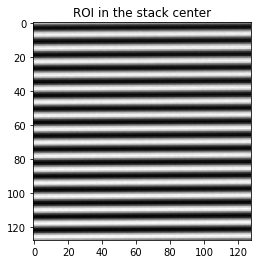

In [5]:
roi = img[im_z//2, roi_h*(N_ROIs_H//2 - 1): roi_h*(N_ROIs_H//2), 
               roi_w*(N_ROIs_W//2 - 1) : roi_w*(N_ROIs_W//2)]
plt.imshow(roi, cmap='gray')
plt.title("ROI in the stack center")

In [6]:
contrast_table = np.empty((im_z, N_ROIs_H, N_ROIs_W))
for f in range(im_z):
    for j in range(N_ROIs_H):
        for i in range(N_ROIs_W):
            roi = img[f,j*roi_h:(j+1)*roi_h, i*roi_w:(i+1)*roi_w]
            contrast_table[f,j,i] = contrast(roi)

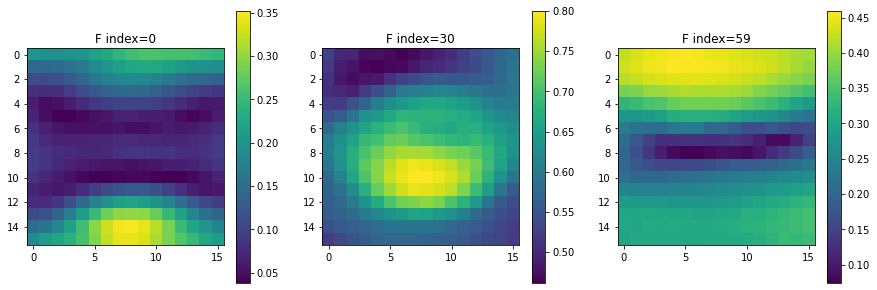

In [172]:
fig = plt.figure(figsize=(15, 5))
for ind, f in enumerate([0, im_z//2, im_z-1]):
    ax = plt.subplot(1, 3, ind+1)
    conmap = ax.imshow(contrast_table[f,:,:])
    ax.set_title("F index=" + str(f))
    plt.colorbar(conmap,ax=ax)

In [173]:
# Save contrast table as TIFF and explore interactively
tif.imsave(save_figs_folder + experiment_key + suffix + "_contrast.tiff", contrast_table)

In [174]:
# save for comparison between experiments
dict_contrast_tables[experiment_key] = contrast_table

In [175]:
dict_contrast_tables.keys()

dict_keys(['2x_ND_filter', '2x_420_20_filter', '2x_470_30_filter', '2x_535_22_filter', '2x_595_31_filter', '2x_630_69_filter', '2x_697_75_filter'])

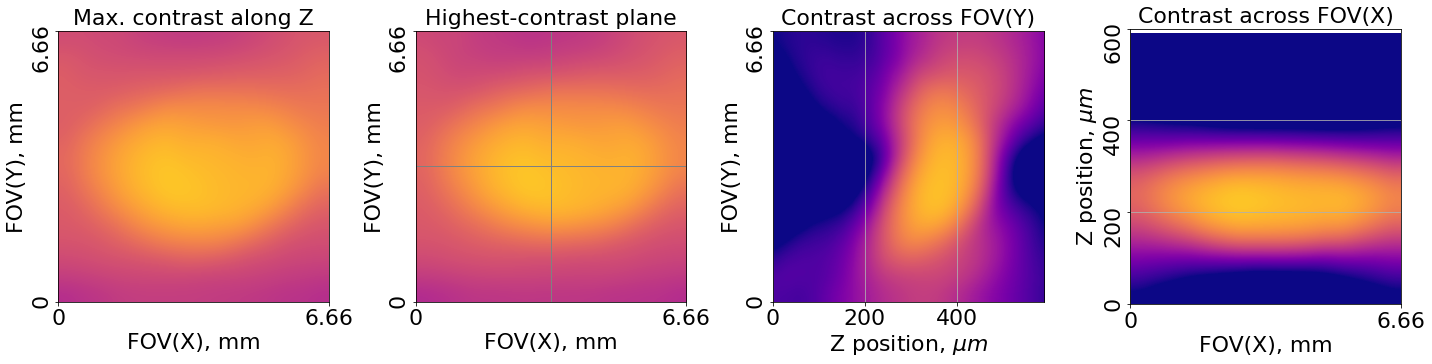

In [176]:
CMIN, CMAX = 0.25, 0.95
USE_COLORBAR = False
FONTSIZE_LABELS = FONTSIZE_TITLES = 22
cmap = 'plasma'
# slice the contrast map along XZ and YZ axis, therough the center
contrast_yz = np.squeeze(contrast_table[:,:,N_ROIs_W//2])
contrast_xz = np.squeeze(contrast_table[:,N_ROIs_H//2,:])
z_contrast_max = np.argmax(contrast_table[:,N_ROIs_H//2,N_ROIs_W//2])
#cmin, cmax = contrast_table.min(), contrast_table.max()
cmin, cmax = CMIN, CMAX

fig = plt.figure(figsize=(20, 10))
#fig.suptitle(f'{LENS_NAME}, {experiment_key}', fontsize=FONTSIZE_TITLES)
# =======================================================================
ax0 = plt.subplot(1, 4, 1)
conmap0 = ax0.imshow(contrast_table.max(axis=0), vmin=cmin, vmax=cmax,
                     extent=[0, x_range[-1], 0, y_range[-1]], 
                     aspect='equal', cmap=cmap, interpolation='bicubic')
ax0.tick_params(axis='both', which='major', labelsize=FONTSIZE_LABELS)
ax0.set_xticks(np.round((0, x_range[-1]),2))
ax0.set_yticks(np.round((0, y_range[-1]),2))
ax0.set_yticklabels(['0', str(np.round(y_range[-1],2))])
ax0.set_xticklabels(['0', str(np.round(x_range[-1],2))])
ax0.tick_params(axis='y', rotation=90)
ax0.set_title("Max. contrast along Z", fontsize=FONTSIZE_TITLES)
ax0.set_xlabel("FOV(X), mm", fontsize=FONTSIZE_LABELS)
ax0.set_ylabel("FOV(Y), mm", fontsize=FONTSIZE_LABELS)
# =======================================================================
ax1 = plt.subplot(1, 4, 2)
ax1.imshow(contrast_table[z_contrast_max,:,:], vmin=cmin, vmax=cmax,
                     extent=[0, x_range[-1], 0, y_range[-1]], 
                     aspect='equal', cmap=cmap, interpolation='bicubic')
ax1.tick_params(axis='both', which='major', labelsize=FONTSIZE_LABELS)
ax1.set_title(f"Highest-contrast plane", fontsize=FONTSIZE_TITLES)
ax1.set_xticks(np.round((0, x_range[-1]),2))
ax1.set_yticks(np.round((0, y_range[-1]),2))
ax1.set_yticklabels(['0', str(np.round(y_range[-1],2))])
ax1.set_xticklabels(['0', str(np.round(x_range[-1],2))])
ax1.tick_params(axis='y', rotation=90)
ax1.set_xlabel("FOV(X), mm", fontsize=FONTSIZE_LABELS)
ax1.set_ylabel("FOV(Y), mm", fontsize=FONTSIZE_LABELS)
ax1.axhline(y_range[-1]/2, c="gray", linewidth=1)
ax1.axvline(x_range[-1]/2, c="gray", linewidth=1)
# =======================================================================
ax2 = plt.subplot(1, 4, 3)
aspect = f_step_um*(im_z-1) / x_range[-1]
conmap3 = ax2.imshow(contrast_yz.T, vmin=cmin, vmax=cmax,
                     extent=[0, f_step_um*(im_z-1), 0, y_range[-1]], 
                     aspect=aspect, 
                     cmap=cmap, interpolation='bicubic')
ax2.tick_params(axis='both', which='major', labelsize=FONTSIZE_LABELS)
ax2.tick_params(axis='y', rotation=90)
ax2.set_yticks(np.round((0, y_range[-1]),2))
ax2.set_yticklabels(['0', str(np.round(y_range[-1],2))])
ax2.set_title("Contrast across FOV(Y)", fontsize=FONTSIZE_TITLES)
ax2.set_xlabel("Z position, $\mu m$", fontsize=FONTSIZE_LABELS)
ax2.set_ylabel("FOV(Y), mm", fontsize=FONTSIZE_LABELS)
ax2.grid(True)
# =======================================================================
ax3 = plt.subplot(1, 4, 4)
conmap1 = ax3.imshow(contrast_xz, vmin=cmin, vmax=cmax, 
                     extent=[0, x_range[-1], 0, f_step_um*(im_z-1)], 
                     aspect=1/aspect, cmap=cmap, interpolation='bicubic')
ax3.set_xticks(np.round((0, x_range[-1]),2))
ax3.tick_params(axis='both', which='major', labelsize=FONTSIZE_LABELS)
ax3.set_yticks([0, 200, 400, 600])
ax3.tick_params(axis='y', rotation=90)
ax3.set_title("Contrast across FOV(X)", fontsize=FONTSIZE_TITLES)
ax3.set_ylabel("Z position, $\mu m$", fontsize=FONTSIZE_LABELS)
ax3.set_xlabel("FOV(X), mm", fontsize=FONTSIZE_LABELS)
ax3.set_xticklabels(['0', str(np.round(x_range[-1],2))])
ax3.grid(True)

if USE_COLORBAR:
    axins = inset_axes(ax0,
                       width="75%",  # width = 5% of parent_bbox width
                       height="5%",  # height : 50%
                       loc='upper center',
                       bbox_to_anchor=(0, 0.2, 1, 1),
                       bbox_transform=ax0.transAxes,
                       borderpad=0,
                       )
    cbar = plt.colorbar(conmap0, cax=axins, ticks=(0.25, 0.55, 0.85), orientation='horizontal')
    cbar.ax.tick_params(labelsize=FONTSIZE_LABELS-2)
fig.tight_layout()

In [177]:
fig.savefig(save_figs_folder + experiment_key + f"_contrast_map({cmap})_min-max({cmin},{cmax}).png")

In [178]:
print(f'Average contrast in the highest-contrast plane: {contrast_table[z_contrast_max,:,:].mean():.2f}')
print(f'Max contrast: {contrast_table.max():.2f}')

Average contrast in the highest-contrast plane: 0.69
Max contrast: 0.87


Sag across FOV_X: 5 um
Sag across FOV_Y: 11 um
DOF (um), by gaussian fitting fwhm: 237


Text(0.1, 0.3, 'Sag across FOV_Y: 11 um')

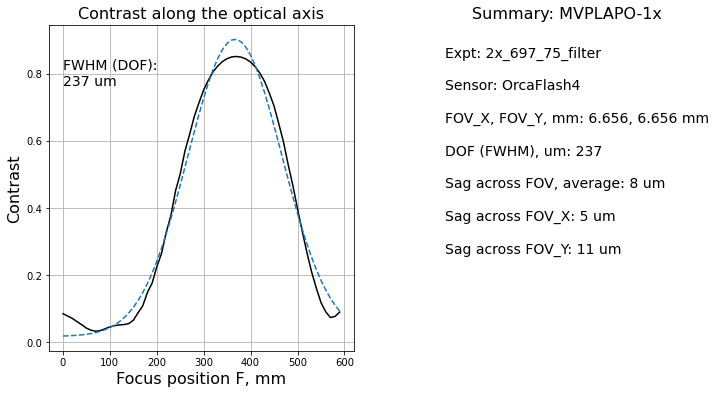

In [179]:
import sys
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'lib'))
import optimization as opt # custom-made optimization library

# gaussian fit of contrast profile along the optical axis
fit_center, fit_sigma, fit_amp, fit_offset = opt.fit_gaussian_1d(contrast_table[:,N_ROIs_H//2,N_ROIs_W//2], f_range)

# Find curvature sag across FOV_X: find peak contrast at the section start and end points
fit_center_left,  _, _, _ = opt.fit_gaussian_1d(contrast_table[:,N_ROIs_H//2,0], f_range)
fit_center_right,  _, _, _ = opt.fit_gaussian_1d(contrast_table[:,N_ROIs_H//2,-1], f_range)

# Find curvature sag across FOV_Y:
fit_center_down, _, _, _ = opt.fit_gaussian_1d(contrast_table[:,0,N_ROIs_W//2], f_range)
fit_center_up, _, _, _ = opt.fit_gaussian_1d(contrast_table[:,-1,N_ROIs_W//2], f_range)

# Average the start, middle, end positions of the peak contrast
sag_x = abs(round(fit_center - 0.5*(fit_center_left + fit_center_right)))
sag_y = abs(round(fit_center - 0.5*(fit_center_up + fit_center_down)))
ave_sag = (sag_x * x_range[-1] + sag_y * y_range[-1]) / (x_range[-1] + y_range[-1])
dof = round(opt.sigma2fwhm(fit_sigma))
print(f"Sag across FOV_X: {sag_x} um")
print(f"Sag across FOV_Y: {sag_y} um")
print(f"DOF (um), by gaussian fitting fwhm: {dof}")


fig = plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(f_range, contrast_table[:,N_ROIs_H//2,N_ROIs_W//2], '-k')
ax1.plot(f_range, opt.gaussian_1d(f_range, fit_center, fit_sigma, fit_amp, fit_offset),'--')
ax1.text(0,0.9*contrast_table[:,N_ROIs_H//2,N_ROIs_W//2].max(),f"FWHM (DOF): \n{dof} um", fontsize=14)
ax1.set_title("Contrast along the optical axis", fontsize=16)
ax1.set_xlabel("Focus position F, mm", fontsize=16)
ax1.set_ylabel("Contrast", fontsize=16)
ax1.grid(True)

ax2 = plt.subplot(1, 2, 2)
ax2.axis('off')
ax2.set_title(f"Summary: {LENS_NAME}", fontsize=16)
ax2.text(0.1, 0.9, f"Expt: {experiment_key}", fontsize=14) 
ax2.text(0.1, 0.8, f"Sensor: {CAMERA}", fontsize=14)
ax2.text(0.1, 0.7, f"FOV_X, FOV_Y, mm: {x_range[-1]:.3f}, {y_range[-1]:.3f} mm", fontsize=14)
ax2.text(0.1, 0.6, f"DOF (FWHM), um: {dof}", fontsize=14)
ax2.text(0.1, 0.5, f"Sag across FOV, average: {round(ave_sag)} um", fontsize=14)
ax2.text(0.1, 0.4, f"Sag across FOV_X: {sag_x} um", fontsize=14)
ax2.text(0.1, 0.3, f"Sag across FOV_Y: {sag_y} um", fontsize=14)


In [180]:
fig.savefig(save_figs_folder + experiment_key + suffix + "_contrast_plot.png")

In [181]:
# Convert the contrast map its simplified version that is 2D contains MAXIMUM contrast position along Z (or F) axis (axis 0). 
# 1. UPSAMPLE the contrast map along Z for smoother function (smaller effective z-step)
from scipy.ndimage import zoom
axis_z = 0 # 0, 1, or 2
upsampling_factor = round(f_step_um) # the result will be 1 µm spaced in Z(or F)
new_shape = np.array(dict_contrast_tables[experiment_key].shape)
new_shape[axis_z] *= upsampling_factor
upsampled_contrast_table = zoom(dict_contrast_tables[experiment_key], zoom=(upsampling_factor, 1, 1), order=3)
# 2. Find maxima along Z
maxima_indices = np.argmax(upsampled_contrast_table, axis=axis_z)
zprofile = np.zeros(upsampled_contrast_table.shape[1:])
for iy in range(contrast_table.shape[1]):
    for ix in range(contrast_table.shape[2]):
        zprofile[iy,ix] = float(maxima_indices[iy,ix]) # the result will be in microns

In [182]:
dict_z_profiles[experiment_key] = zprofile

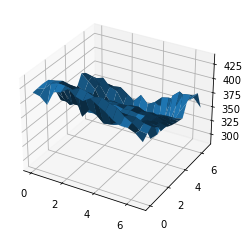

In [183]:
# #%matplotlib notebook # uncomment for interactive features
# X, Y  = np.meshgrid(x_range, y_range)
# fig = plt.figure()
# ax  = fig.add_subplot(111,projection='3d')
# ax.plot_surface(X,Y,zprofile)

In [10]:
# LOAD THE PRE_COMPUTED DICT
dict_z_profiles = np.load(save_figs_folder + f'{LENS_NAME}-zoom2x-DBE(20mm)-distortion-all-filters_dict_z_profiles.npz')

In [12]:
# subtract linear trend (from slide tilt) of ND-filter experiment
trend_key = "2x_ND_filter"

profile_Y = dict_z_profiles[trend_key][:,N_ROIs_W//2]
profile_X = dict_z_profiles[trend_key][N_ROIs_H//2,:]

lin_fit_param_Y = opt.fit_linear(profile_Y, np.arange(len(profile_Y)))
profile_Y_trend = np.arange(len(profile_Y)) * lin_fit_param_Y[0]

lin_fit_param_X = opt.fit_linear(profile_X, np.arange(len(profile_X)))
profile_X_trend = np.arange(len(profile_X)) * lin_fit_param_X[0]

filter 420/20, max sag along Y: 198 µm
filter 470/30, max sag along Y: 126 µm
filter 535/22, max sag along Y: 81 µm
filter 595/31, max sag along Y: 87 µm
filter 630/69, max sag along Y: 83 µm
filter 697/75, max sag along Y: 74 µm
filter ND filter, max sag along Y: 81 µm

filter 420/20, max sag along X: 38 µm
filter 470/30, max sag along X: 28 µm
filter 535/22, max sag along X: 23 µm
filter 595/31, max sag along X: 20 µm
filter 630/69, max sag along X: 15 µm
filter 697/75, max sag along X: 17 µm
filter ND filter, max sag along X: 48 µm

Axial position: 218 µm 2x_420_20_filter
Axial position: 243 µm 2x_470_30_filter
Axial position: 295 µm 2x_535_22_filter
Axial position: 334 µm 2x_595_31_filter
Axial position: 354 µm 2x_630_69_filter
Axial position: 371 µm 2x_697_75_filter
Axial position: 319 µm 2x_ND_filter


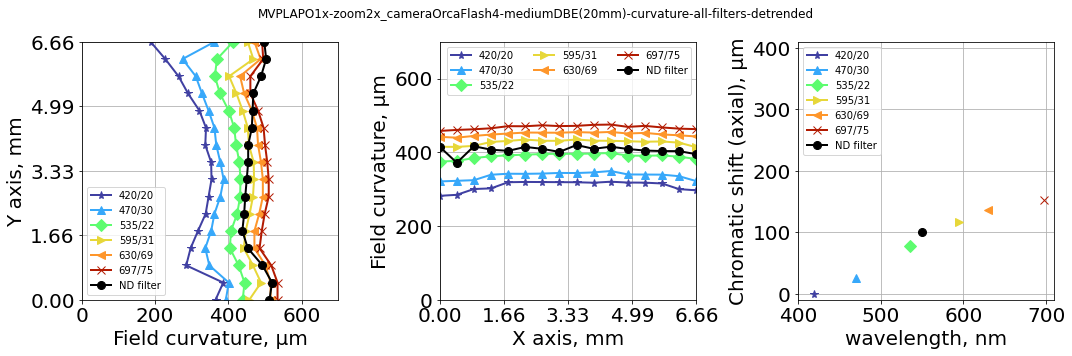

In [32]:
# plot the middle sections of Z-profile along Y axis (longest axis) and X (shortest)
fig = plt.figure(figsize=(15, 5))
fig_title = f"{LENS_NAME}_camera{CAMERA}-mediumDBE(20mm)-curvature-all-filters-detrended"
fig.suptitle(fig_title)
FONTSIZE_LABELS = FONTSIZE_TITLES = 20
z_plotting_range = np.array((0, 700))

ax0 = plt.subplot(1, 3, 1)
ax0.tick_params(axis='both', which='major', labelsize=FONTSIZE_LABELS)
for (ic, key) in enumerate(sorted(dict_z_profiles.keys())):
    profile_Y = dict_z_profiles[key][:,N_ROIs_W//2] - profile_Y_trend
    ax0.plot(profile_Y - z_plotting_offset, y_range, label=NAMES[key], color=COLORS[key], lw=2, marker=MARKERS[key], ms=8)
    print(f"filter {NAMES[key]}, max sag along Y: {int(profile_Y.max() - profile_Y.min())} µm")
ax0.set_ylim([0, y_range[-1]])
ax0.set_xlim(z_plotting_range - z_plotting_range[0])
ax0.set_ylabel('Y axis, mm', fontsize=FONTSIZE_LABELS)
ax0.set_xlabel('Field curvature, µm', fontsize=FONTSIZE_LABELS)
ax0.set_yticks(np.round((0, y_range[-1]/4, y_range[-1]/2, y_range[-1]*3/4, y_range[-1]),2))
#ax0.set_xticks(np.arange(0, z_plotting_range[1] - z_plotting_offset, 200))
ax0.legend(loc='best')
ax0.grid(True)

print()
ax1 = plt.subplot(1, 3, 2)
ax1.tick_params(axis='both', which='major', labelsize=FONTSIZE_LABELS)
for (ic, key) in enumerate(sorted(dict_z_profiles.keys())):
    profile_X = dict_z_profiles[key][N_ROIs_H//2,:] - profile_X_trend
    ax1.plot(x_range, profile_X - z_plotting_offset, label=NAMES[key], color=COLORS[key], lw=2, marker=MARKERS[key], ms=8)
    print(f"filter {NAMES[key]}, max sag along X: {int(profile_X.max() - profile_X.min())} µm")
ax1.set_ylim(z_plotting_range - z_plotting_range[0])
ax1.set_xlim([0, x_range[-1]])
ax1.set_ylabel('Field curvature, µm', fontsize=FONTSIZE_LABELS)
ax1.set_xlabel('X axis, mm', fontsize=FONTSIZE_LABELS)
ax1.set_xticks(np.round((0, x_range[-1]/4, x_range[-1]/2, x_range[-1]*3/4, x_range[-1]),2))
ax1.legend(loc='best',ncol=3)
ax1.grid(True)

print()
ax2 = plt.subplot(1, 3, 3)
axial_position = {}
ax2.tick_params(axis='both', which='major', labelsize=FONTSIZE_LABELS)
for (ic, key) in enumerate(sorted(dict_z_profiles.keys())):
    profile_X = dict_z_profiles[key][N_ROIs_H//2,:] - profile_X_trend
    axial_position[key] = profile_X[len(profile_X)//2]
    ax_offset = axial_position['2x_420_20_filter']
    print('Axial position:', int(axial_position[key]), 'µm', key)
    ax2.plot(WAVELENGTH[key], axial_position[key] - ax_offset, label=NAMES[key], color=COLORS[key], lw=2, marker=MARKERS[key], ms=8)
ax2.set_xlim([400, 710])
ax2.set_ylim([-10, 410])
ax2.set_ylabel('Chromatic shift (axial), µm', fontsize=FONTSIZE_LABELS)
ax2.set_xlabel('wavelength, nm', fontsize=FONTSIZE_LABELS)
ax2.legend(loc='upper left')
ax2.grid(True)

fig.tight_layout()

In [33]:
fig.savefig(save_figs_folder + fig_title + ".png", dpi=200)

In [189]:
# SAVE the DICTIONARY for later
#np.savez(save_figs_folder + f'{LENS_NAME}-zoom2x-DBE(20mm)-distortion-all-filters_dict_z_profiles', **dict_z_profiles)

# LOAD THE PRE-COMPUTED DICT
#d = np.load(save_figs_folder + '{LENS_NAME}-zoom2x-DBE(20mm)-distortion-all-filters_dict_z_profiles.npz')